# Fake news detection

#### Краткое описание работы

pretrained navec embeddings as starting point for weights in nn.Embeddings + LSTM + Linear

CrossEntropyLoss + Adam

#### импорты

In [ ]:
!pip install -q navec
!gdown 1wesSqUWp55XF1t-fiFIEGzOK7fyPZg_e -O train.tsv
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

Downloading...
From: https://drive.google.com/uc?id=1wesSqUWp55XF1t-fiFIEGzOK7fyPZg_e
To: /content/train.tsv
100% 712k/712k [00:00<00:00, 97.6MB/s]
--2023-01-27 16:21:26--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  13.8MB/s    in 1.8s    

2023-01-27 16:21:29 (13.8 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import os
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import pprint

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from navec import Navec
from nltk.util import ngrams

pretty_print = pprint.PrettyPrinter()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### загрузка данных

In [ ]:
navec_news = Navec.load('navec_news_v1_1B_250K_300d_100q.tar')
data = pd.read_csv('train.tsv', sep='\t')  
data.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


#### разделим на train и test

In [ ]:
# разделим на train и test
train_data, test_data = train_test_split(data, shuffle = True, test_size=0.15, random_state=44)
train_data, valid_data = train_test_split(train_data, shuffle = True, test_size=0.15, random_state=44)

# обновим идексы
train_data.reset_index(drop = True, inplace = True)
valid_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)
 
#посмотрим на наши датасеты
print('train:')
print(train_data.describe())
print('valid:')
print(valid_data.describe())
print('test:')
print(test_data.describe())

# токенайзер
tokenizer = nltk.WordPunctTokenizer()

# маппинг из слов в индексы для navec
word2idx = {word: idx for idx, word in enumerate(navec_news.vocab.words)}

train:
           is_fake
count  4159.000000
mean      0.496994
std       0.500051
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000
valid:
          is_fake
count  735.000000
mean     0.515646
std      0.500095
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000
test:
          is_fake
count  864.000000
mean     0.501157
std      0.500288
min      0.000000
25%      0.000000
50%      1.000000
75%      1.000000
max      1.000000


итераторы для dataloader

In [ ]:
train_iter = list(zip(train_data['title'], 
                      train_data['is_fake']))

valid_iter = list(zip(valid_data['title'], 
                      valid_data['is_fake']))

test_iter = list(zip(test_data['title'], 
                     test_data['is_fake']))

### EDA

сколько незнакомых слов есть в трейн части для предобученных эбеддингов от navec

In [ ]:
all_words = []
unknown_words = []

for title in tqdm(train_data['title']):

    # разбиваем заголовок на токены
    tokens = tokenizer.tokenize(title.lower())

    # фильтруем токены по длине, избавляемся от стопслов и чисел
    filtered_tokens = [token for token in tokens if (len(token) > 2) and 
                       token not in stopwords.words('russian') and 
                       token.isalpha()]

    for word in filtered_tokens:
        if word not in navec_news.vocab.words:
            unknown_words.append(word)
        else:
            all_words.append(word)

unknown_words = set(unknown_words)
all_words = set(all_words)

print('Всего слов:', len(all_words))
print('Незнакомых слов:', len(unknown_words))

  0%|          | 0/4606 [00:00<?, ?it/s]

Всего слов: 14699
Незнакомых слов: 1117


### dataloader

In [ ]:
navec_news.vocab['<pad>']

250001

In [ ]:
def encode_word(word):
    if word in word2idx.keys():
        return word2idx[word]
    return word2idx['<unk>']

In [ ]:
def collate_fn(batch):

    labels = []
    filtered_batch = []

    for title, label in batch:

        tokens = tokenizer.tokenize(title.lower())
        filtered_tokens = [encode_word(token) for token in tokens if (len(token) > 2) and 
                           token not in stopwords.words('russian') and 
                           token.isalpha()]

        filtered_batch.append(filtered_tokens)
        labels.append(label)

    max_len = max(len(row) for row in filtered_batch)

    input_embeds = torch.empty((len(batch), max_len), dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    for idx, row in enumerate(filtered_batch):
        to_pad = max_len - len(row)
        input_embeds[idx] = torch.cat((torch.tensor(row), torch.zeros(to_pad).fill_(250001))) # navec_news.vocab['<pad>'] = 250001

    return input_embeds, labels

### train, test functions

In [ ]:
# freeze or unfreeze embeddings weights
def freeze_embeddings(model, req_grad=False):
    embeddings = model.embeddings
    for c_p in embeddings.parameters():
        c_p.requires_grad = req_grad

def trainer(model, train_loader, valid_loader, loss_function, optimizer, scheduler, cfg):
    """
    trainer итерируется по кол-ву эпох и вызывает функцию train_epoch
    cfg.count_of_epoch - кол-во эпох
    cfg.batch_size - размер батча
    train_loader, valid_loader - данные для обучения
    model - модель нейронной сети
    loss_function - функция потерь
    optimizer - оптимизатор
    scheduler - lr scheduler
    cfg.lr - скорость обучения
    """
    min_valid_loss = np.inf

    # in this folder will save model weights
    if not os.path.exists(f'/content/model_weights/{cfg["model_name"]}'):
        os.makedirs(f'/content/model_weights/{cfg["model_name"]}')

    # freeze embeddings for one epoch
    freeze_embeddings(model, req_grad=False)

    for e in tqdm(range(cfg['count_of_epoch']), desc='epochs'):

        # train
        epoch_loss = train_epoch(train_generator=train_loader, 
                                        model=model, 
                                        loss_function=loss_function, 
                                        optimizer=optimizer)

        # valid
        valid_loss = 0.0
        model.eval()
        valid_loss, valid_accuracy = tester(model=model, 
                                            test_loader=valid_loader,
                                            loss_function=loss_function)
        
        scheduler.step()

        if e > 1:
            # unfreeze embeddings
            freeze_embeddings(model, req_grad=True)

        # log things
        trainer_log(epoch_loss, valid_loss, valid_accuracy, e, optimizer.param_groups[0]['lr'], min_valid_loss, cfg)

        # saving models
        if min_valid_loss > valid_loss:
            if cfg['print_logs']:
                print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
            min_valid_loss = valid_loss
            torch.save(model.state_dict(), f'/content/model_weights/{cfg["model_name"]}/saved_model_{e}.pth')
        if cfg['print_logs']:
            print()

def train_epoch(train_generator, model, loss_function, optimizer):
    """
    внутри train_epoch итерируемся по батчам внутри батчгенератора
    train_generator - батчгенератора
    model - модель нейронной сети
    loss_function - функция потерь
    optimizer - оптимизатор
    """
    epoch_loss = 0
    total = 0

    for it, (features, labels) in enumerate(train_generator):

        batch_loss = train_on_batch(model, 
                                    features.to(device),
                                    labels.to(device), 
                                    optimizer, loss_function)
            
        epoch_loss += batch_loss*len(labels)
        total += len(labels)
    return epoch_loss/total

def train_on_batch(model, features, labels, optimizer, loss_function):
    """
    в train_on_batch обучаемся на одном батче
    model - модель нейронной сети
    x_batch - фичи
    y_batch - таргеты(метки классов)
    optimizer - оптимизатор
    loss_function - функция потерь
    """
    model.train()
    optimizer.zero_grad()  

    output = model(features)
    
    loss = loss_function(output, labels)
    loss.backward()
    optimizer.step()

    return loss.cpu().item()

def tester(model, test_loader, loss_function = None, print_stats=False):

    pred = []
    real = [] 
    loss = 0
    model.eval()

    for it, (features, labels) in enumerate(test_loader):
        
        with torch.no_grad():
            output = model(features.to(device))

            if loss_function != None:
                loss += loss_function(output, labels.to(device))

        pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
        real.extend(labels.cpu().numpy().tolist())

    f1 = f1_score(real, pred)

    if print_stats:
        print(classification_report(real, pred, zero_division = 0))

    if loss_function != None:
        return loss.cpu().item()/len(test_loader), f1
    else:
        return f1

def trainer_log(train_loss, valid_loss, valid_f1, epoch, lr, min_val_loss, cfg):
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    if cfg['print_logs']:
        print(f'train loss on {str(epoch).zfill(3)} epoch: {train_loss:.6f} with lr: {lr:.10f}')
        print(f'valid loss on {str(epoch).zfill(3)} epoch: {valid_loss:.6f}')
        print(f'valid accuracy: {valid_f1:.2f}')

### LSTM model

In [ ]:
class LSTM(torch.nn.Module):
    
    def __init__(self, output_dim=2, emb_dim = 300, hidden_dim = 100, 
                 num_layers = 3, bidirectional = True, p=0.3):
        super(LSTM, self).__init__()

        self.embeddings = nn.Embedding(len(word2idx), emb_dim)
        self.lstm = torch.nn.LSTM(emb_dim, hidden_dim, num_layers, 
                                     bidirectional=bidirectional, 
                                     batch_first=True, dropout=p)
        self.linear = torch.nn.Linear(
            2*num_layers*int(bidirectional + 1)*hidden_dim,
            output_dim)
        
    def forward(self, input):
        x = self.embeddings(input)
        # x = x.permute(0, 2, 1)
        _, (h, c) = self.lstm(x)
        x = torch.cat([h, c], dim=0).transpose(0, 1)
        x = x.reshape(len(input), -1)
        return self.linear(x)

### pipeline

In [ ]:
def pipeline(cfg, saved_model=None, to_train=True, to_test=True, to_predict=False):

    # build the model
    model = build_model(cfg, saved_model)

    # data and optimization 
    train_loader, valid_loader, test_loader, criterion, optimizer, scheduler = make(model, cfg)

    print(model)
    print()
    print('config:')
    pretty_print.pprint(cfg)
    print()
    print('running on device:', device, '\n')

    if to_train:
        trainer(model, train_loader, valid_loader, 
                criterion, optimizer, scheduler, cfg)

    if to_test:
        tester(model, test_loader, print_stats=True)

    return model

def build_model(cfg, saved_model=None):
    
    if cfg['model_name'] == 'LSTM':
        model = LSTM(output_dim = 2, 
                     emb_dim = 300, 
                     hidden_dim = 100, 
                     num_layers = 3, 
                     bidirectional = True,
                     p = 0.5)

    if saved_model == None:
        # liniar layers init
        model.apply(init_weights)
        # ambeddings init
        with torch.no_grad():
            for word, idx in word2idx.items():
                if word in navec_news:
                    model.embeddings.weight[idx] = torch.from_numpy(navec_news[word])
        # model on device
        model = model.to(device)
    if saved_model != None:
        model.load_state_dict(torch.load(saved_model, map_location=torch.device(device)))
        model = model.to(device)

    return model

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

def make(model, cfg):

    train_loader = DataLoader(train_iter, batch_size=cfg['batch_size'], 
                                    shuffle=True, num_workers=2, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_iter, batch_size=cfg['batch_size'], 
                                shuffle=False, num_workers=2, collate_fn=collate_fn)
    test_loader = DataLoader(test_iter, batch_size=cfg['batch_size'], 
                                shuffle=False, num_workers=2, collate_fn=collate_fn)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['lr'])
    scheduler = StepLR(optimizer, cfg['step_size'], cfg['step_gamma'])
    
    return train_loader, valid_loader, test_loader, criterion, optimizer, scheduler

### обучение

In [ ]:
%%time
cfg = dict(count_of_epoch=50, batch_size=256, lr=1e-4, 
           criterion='CrossEntropyLoss', 
           optimizer='Adam', scheduler='StepLR', 
           step_size = 150, step_gamma = 0.5,
           project='fake_news_detection', model_name='LSTM', print_logs=True)

train_losses, valid_losses = [], []
epochs = range(cfg['count_of_epoch'])

model = pipeline(cfg, saved_model=None, to_train=True, to_test=True)
torch.save(model.state_dict(), f'/content/model_weights/{cfg["model_name"]}/saved_model_last.pth')

LSTM(
  (embeddings): Embedding(250002, 300)
  (lstm): LSTM(300, 100, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=1200, out_features=2, bias=True)
)

config:
{'batch_size': 1024,
 'count_of_epoch': 50,
 'criterion': 'CrossEntropyLoss',
 'lr': 0.0001,
 'model_name': 'LSTM',
 'optimizer': 'Adam',
 'print_logs': True,
 'project': 'fake_news_detection',
 'scheduler': 'StepLR',
 'step_gamma': 0.5,
 'step_size': 150}

running on device: cpu 



epochs:   0%|          | 0/50 [00:00<?, ?it/s]

train loss on 000 epoch: 0.692321 with lr: 0.0001000000
valid loss on 000 epoch: 0.683964
valid accuracy: 0.54
Validation Loss Decreased(inf--->0.683964) 	 Saving The Model

train loss on 001 epoch: 0.679701 with lr: 0.0001000000
valid loss on 001 epoch: 0.673915
valid accuracy: 0.54
Validation Loss Decreased(0.683964--->0.673915) 	 Saving The Model

train loss on 002 epoch: 0.669536 with lr: 0.0001000000
valid loss on 002 epoch: 0.662411
valid accuracy: 0.63
Validation Loss Decreased(0.673915--->0.662411) 	 Saving The Model

train loss on 003 epoch: 0.658228 with lr: 0.0001000000
valid loss on 003 epoch: 0.650266
valid accuracy: 0.67
Validation Loss Decreased(0.662411--->0.650266) 	 Saving The Model

train loss on 004 epoch: 0.646586 with lr: 0.0001000000
valid loss on 004 epoch: 0.638891
valid accuracy: 0.69
Validation Loss Decreased(0.650266--->0.638891) 	 Saving The Model

train loss on 005 epoch: 0.635063 with lr: 0.0001000000
valid loss on 005 epoch: 0.627217
valid accuracy: 0.69

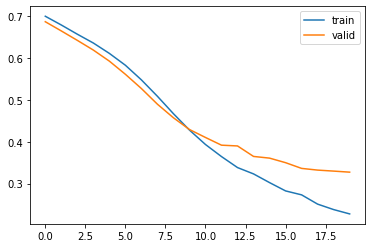

In [ ]:
plt.plot(list(range(len(train_losses))), train_losses, label = 'train')
plt.plot(list(range(len(train_losses))), valid_losses, label = 'valid')
plt.legend()
None